In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm,chi2
import matplotlib.pyplot as plt
from scipy import stats

from statsmodels.stats.weightstats import ztest

# AB Testing Done right

Based on the data type you want to analyse and your sample size,
the tests to apply changes. In the following we'll show you how to do it.

## Computing sample size and duration based on significance lvl

In [2]:
# current (base) mean recorded (ex: convertion rate)
current_conv_rate =  0.1
std_dev = 1
# desired uplift:  the minimum detectable effect or minimum effect size (in pct of base rate)
desired_uplift = 0.5 # expected current_conv_rate+ current_conv_rate*desired_uplift
#statistical power "1-β" is used to represent statistical power, where β (beta) is the probability of failing to reject the null hypothesis when it is false.
statistical_p = 0.8

#  probability of rejecting the null hypothesis when it is true
alpha = 0.05
#how confident we are with the results
confidence_level = 1-alpha

#one sided or two sided: 
side = 2

# number of events currently happening (and expected to happen)
number_of_events_per_weeek = 1000


#### Sample size needed for comparing the means of two normally distributed samples :


In [3]:
# normal z-value for significance lvl alpha = 0.05
Za = norm.ppf(1-alpha/side)
# normal z-value for the power of 80% 
Zb = norm.ppf(statistical_p)

n = np.power(Za+Zb,2)*2*(std_dev)**2 / ( (current_conv_rate*(desired_uplift))**2)
print(f'Number of events needed per group: {n}')
print(f'Number of weeks needed: {n/number_of_events_per_weeek}')

Number of events needed per group: 6279.103787479269
Number of weeks needed: 6.2791037874792694


#### Sample size needed for comparing the means of two binomial proportions using a two sided test:
( for un balanced samples check: https://towardsdatascience.com/required-sample-size-for-a-b-testing-6f6608dd330a ) 


In [4]:
from statsmodels.stats.power import zt_ind_solve_power
from statsmodels.stats.proportion import proportion_effectsize as es


In [5]:
n = zt_ind_solve_power(effect_size=es(prop1=current_conv_rate, prop2=current_conv_rate+current_conv_rate*desired_uplift), alpha=alpha, power=statistical_p, alternative="two-sided")
print(f'Number of events needed per group: {n}')
print(f'Number of weeks needed: {n/number_of_events_per_weeek}')

Number of events needed per group: 680.3526619127882
Number of weeks needed: 0.6803526619127882


## Importing the data

We assume that you want to compare two samples. 

One from the Base cohort (control) and the second one from the tested cohort (variant).

You can either choose to imput the full random variable produced by both cohorts or only provide the mean, std and number of sample in both cohorts.

In [6]:
# allow to compute the various metrics provided in the df
def compute_sample_stat(df):
        
    return df.mean(),df.std(),len(df), df.columns

In [7]:
# Importing full samples
# each row being a costumer using the app with ads activate or not activated ( and buying in game accessories ) 
df_control = pd.read_csv('amount_spent_in_game_no_ads.csv',index_col=0)
df_variant = pd.read_csv('amount_spent_in_game_ads_activated.csv',index_col=0)

mean_c, std_c, N_c, metrics = compute_sample_stat(df_control)
mean_v, std_v, N_v, metrics = compute_sample_stat(df_variant)


df_variant.head()

,total_fees
0,2.641414
1,0.000000
2,1.123917
3,9.118917
4,4.554669


In [8]:
## Plugging mean and std

#mean_c, std_c, N_c = 1,1,1
#mean_v, std_v, N_v = 1,1,1

## Setting up hypothesis

standard formulation is to set:
- H_0: null hypothesis as the equality hypothesis
- H_1: negates the null hypothesis


The alternative hypothesis can be directional or non-directional. The hypothesis is directional when the alternative hypothesis defines an orientation, either greater than (>) or less than (<) that established in the null hypothesis.

On the other hand, the hypothesis is non-directional when the alternative hypothesis does not define an orientation explicitly, that is, it only determines that the hypothesis is different from the null hypothesis.


*Significance level*

To check if the statement in the null hypothesis is correct, we need to define a significance level. Commonly, the significance level is 5% and is interpreted as follows: if the probability of our sample mean is less than or equal to 5%, then the null hypothesis is rejected, on the other hand, if the probability of our sample mean is greater than 5%, then the null hypothesis remains or fails to be rejected.

In [9]:
alpha = 0.05 # significance lvl 5%
if side == 2:
    directional = False
else:
    directional = True  # see above for definition

if directional:
    alpha_value = alpha
else: 
    alpha_value = alpha /2

## Choosing a test (for continous data)

Depending the number of samples, types of hypothesis (directional / non directional ) and the data distribution, a different test will be chosen.

We also need to define the alpha / significance threshold that we can accept (as maximum likelihood to see H0 and still reject it).

Then the final choice is taken using the p-value (probability of occurence of H0). The lower it is, the more confident we can be in rejecting H₀.


### if N>30 and continuous value testing: Z test


H₀: the average "fees generated" is the same for the two versions


H₁: the average "fees generated" is higher for version B


 If we know the mean and the variance, the z-test would be the most appropriate option.

We recall that for N>30 the law of large number applies and the mean behaves as a normal distribution.


Conceptually, Z represents the number of standard deviations the observed difference of means is away from 0. The higher this number, the lesser the likelihood of H₀.


From the formula of Z, you can also get the intuition that the smaller the difference to prove is, the more samples you need.



This z-score gives us the number of standard deviations at which a sample mean is found concerning the population mean.

all the values of the sample mean concerning the population mean are normally distributed, therefore, at least 95% of all the sample means fall within 2 standard deviations of the population mean, that is, there is less than 5% probability of obtaining a sample mean beyond 2 standard deviations of the population mean.

Then, if the probability of occurrence (or p-value) is less than or equal to 5%, the null hypothesis is rejected, on the other hand, if the probability of occurrence (or p-value) is greater than 5%, the null hypothesis is retained.

In [10]:
print(mean_c)
print(mean_v)

total_fees    5.589856
dtype: float64
total_fees    6.362558
dtype: float64


In [11]:
Z = (mean_v - mean_c)/np.sqrt(std_v**2/N_v + std_c**2/N_c)
pvalue = 1-norm.cdf(Z)

print("Z-score: {0}\np-value: {1}".format(Z.values,pvalue))

Z-score: [0.9976947]
p-value: [0.15921371]


In [12]:
alpha_value

0.025

the critical values (areas under the curve) for the Z test are: 

In [13]:
print(alpha_value)
reject1 = norm.ppf(1-alpha_value)
print(reject1)
if not directional:
    reject2 = norm.ppf(alpha_value)
    print(reject2)

0.025
1.959963984540054
-1.9599639845400545


In [14]:
print(f'Zvalue: {Z.values}')
proba_outside = 1-norm.cdf(Z)
if not directional:
    proba_outside = proba_outside* 2
print(f'Proba to be above Z: {proba_outside}')

Zvalue: [0.9976947]
Proba to be above Z: [0.31842743]


we find that the probability of observing a standard normal value below 0.9975 is approximately 0.69 ( or norm.cdf(Z) ) . 
http://www.z-table.com/ 

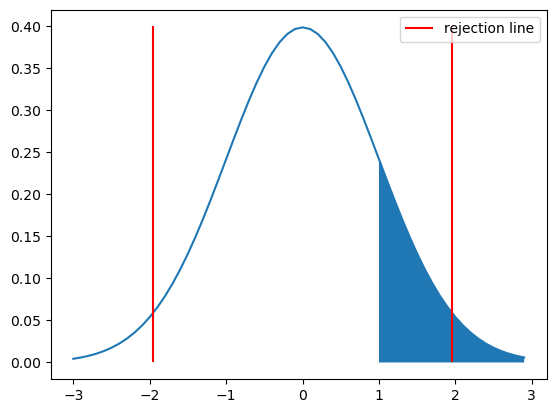

In [15]:
z = np.arange(-3, 3, 0.1)
plt.plot(z, norm.pdf(z))
plt.fill_between(z[z>Z.total_fees], norm.pdf(z[z>Z.total_fees]))
plt.vlines(reject1, 0,0.4,color='red',label='rejection line')
if not directional:
    plt.vlines(reject2, 0,0.4,color='red')
plt.legend()
plt.show()

In [16]:
if proba_outside>alpha:
    print('Cannot reject H0, the proba to be inside is too high')
else:
    print(f'We reject H0 in favor of H1 with level of significance {alpha*100}%')

Cannot reject H0, the proba to be inside is too high


### N<30: student t-test

- one sample t-test: if we have only the mean of a sample A and want to compare to the "population mean" or just a value
- two sample t-test: we compare the means of the two samples


- H0 : population mean is greater or equal to sample mean (μ> = x)
- H1 : population mean is less than sample mean (μ< x)

In [17]:
1-alpha_value

0.975

In [18]:
# calculate t statistics
# here we consider mean_c as the population mean
t = abs(mean_c - mean_v) / std_v
print('t static:',t)
# two-tailed critical value at alpha = 0.05
# df = degree of freedoms ( nb of samples -1 )
t_crit = stats.t.ppf(q=1-alpha_value, df= len(df_variant)-1)
print("Critical value for t two tailed:",t_crit)

#get two-tailed p value
p_value = 2*(1-stats.t.cdf(x=t, df=len(df_variant)-1))
print("p-value:",p_value)

t static: total_fees    0.006994
dtype: float64
Critical value for t two tailed: 1.9600577842724116
p-value: [0.99441938]


### One tailed (side =1)

In [19]:
# one-tailed critical value at alpha = 0.05
t_crit = stats.t.ppf(q=1-alpha_value, df=len(df_variant)-1)
print("Critical value for t one tailed:",t_crit)


# get one-tailed p value
p_one = 1-stats.t.cdf(x=t, df=len(df_variant)-1)
print("p-value for one tailed:",p_one)

Critical value for t one tailed: 1.9600577842724116
p-value for one tailed: [0.49720969]


 we cannot reject H0 if p> 0.05

### 2 tailed (side = 2)

In [20]:
# pooled sample variance
var = ( ((N_v-1)*std_v**2) + ((N_c-1)*std_c**2) ) / (N_v+N_c-2)
std_error = np.sqrt(var * (1.0 / N_v + 1.0 / N_c))

In [21]:
t = abs(mean_c - mean_v) / std_error
print('t static:',t)
# two-tailed critical value at alpha = 0.05
t_c = stats.t.ppf(q=1-alpha_value, df=max(N_v,N_c))
print("Critical value for t two tailed:",t_c)

#get two-tailed p value
p_value = 2*(1-stats.t.cdf(x=t, df=max(N_v,N_c)))
print("p-value:",p_value)

t static: total_fees    1.003818
dtype: float64
Critical value for t two tailed: 1.9600558945269764
p-value: [0.31547587]


## Non inferiority testing

The error we want to avoid the most is the error of failing to implement a new solution, which is about equal, or better than what we currently have.

decision about a noninferiority margin should be made. A noninferiority margin is such a negative difference, or relative difference, that can be tolerated while still considering the performance of the control and variant about the same

Null hypothesis:  variant(s) < control or more precisely variant(s) < control – δ

the varient is worse than the control and some tolerance threshold


Using the degree of freedom and the level of significance, one can get minimum t value to have ( if greater we can rejet h0)

In [22]:
def non_inferiority_ttest(sample1, sample2, relative_difference, equal_variance=False,
                          increase_good=True):
    '''
    Perform a one-sided t-test with a non-inferiority threshold for two independent samples.
    mean1/2: group mean
    stddev1/2: standard deviation of each group
    n1/2: number of observations in each group
    relative_difference: threshold as a percentage of the base group (e.g. 0.1=10% difference)
    equal_variance: if False, uses Welch's t-test.
    
    
    increase_good: if True, Ho: mean2 <= mean1 - threshold. Else Ho: mean2 >= mean1 + threshold.
    Returns: 
    '''
    mean1 = sample1.mean()
    stddev1 = sample1.std()
    n1 = len(sample1)
    
    mean2 = sample2.mean()
    stddev2 = sample2.std()
    n2 = len(sample2)
    
    delta = relative_difference * mean1

    if increase_good:
        threshold = mean1 - delta
    else:
        threshold = mean1 + delta
    
    print('threshold:',threshold)
    print('variant mean:',mean2)
    
    
    #ttest_ind_from_stats
    if len(sample1)>30:
        stat = (mean2 - threshold)/np.sqrt(stddev2**2/n2 + stddev1**2/n1)
        if increase_good:
            pvalue = 1-norm.cdf(stat)
        else:
            pvalue = norm.cdf(stat)
            
        print("Z-score: {0}\np-value: {1}".format(stat,pvalue))
   
        
    else:
        stat, pval = stats.ttest_ind_from_stats(mean1=threshold, 
                                       std1=stddev1, 
                                       nobs1=n1, 
                                       mean2=mean2, 
                                       std2=stddev2, 
                                       nobs2=n2, 
                                       equal_var=equal_variance)
        if increase_good:
            pvalue = pval/2
        else:
            pvalue = 1 - pval/2.0
        
    
    return stat, pvalue

In [23]:
print('control mean: ',df_control['total_fees'].mean() ) 
print('variant mean: ',df_variant['total_fees'].mean() ) 

control mean:  5.58985601273073
variant mean:  6.362557514767675


In [24]:
#H0: mean_v <= mean_c - treshold
t_val,p_val = non_inferiority_ttest(df_control['total_fees'],df_variant['total_fees'],
                                    relative_difference=0.05)

threshold: 5.3103632120941935
variant mean: 6.362557514767675
Z-score: 1.3585694753470399
p-value: 0.0871415266540716


In [25]:
if p_val < alpha:
    print(f'we can safely (alpha = {alpha}%) reject h0 with pval = {p_val}')
else:
    print('we cannot reject h0')

we cannot reject h0


## Testing binary results: (converted / not converted)

example with random data

### Chi test

#### Modelling H_0

In [26]:
# H0 assumes that we have same conversion:

total_control = 21405
converted_control = 3349
not_converted_control = total_control - converted_control


total_variant = 19177
converted_variant_o = total_variant*converted_control/total_control
not_converted_variant_o = total_variant - converted_variant_o


O =np.array([total_control,converted_variant_o,
              not_converted_control,not_converted_variant_o])


In [28]:
(converted_variant_o+converted_control)/ ( total_control+total_variant)

0.15645877131511327

In [29]:
#conversion data:
# H1:

total_control = 21405
converted_control = 3349
not_converted_control = total_control - converted_control

total_variant = 19177
converted_variant = 3102
not_converted_variant = total_variant - converted_variant


T = np.array([total_control,converted_variant,
              not_converted_control,not_converted_variant])

In [30]:
(converted_variant+converted_control)/ ( total_control+total_variant)

0.15896210142427677

In [31]:
D = np.sum(np.square(T-O)/T)
pvalue = chi2.sf(D, df=1)

print("distance d: {0}\np-value: {1}".format(D,pvalue))


distance d: 3.969090780141167
p-value: 0.0463427892729067


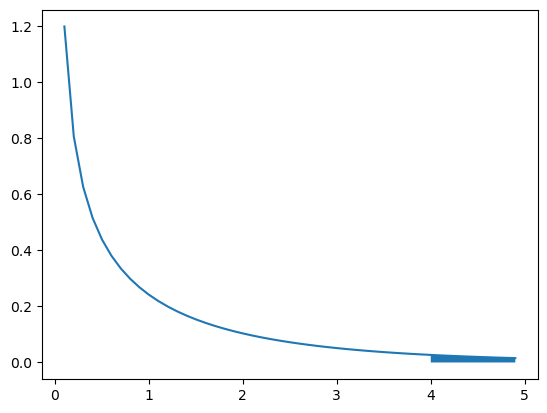

In [32]:
d = np.arange(0, 5, 0.1)
plt.plot(d, chi2.pdf(d, df=1))
plt.fill_between(d[d>D], chi2.pdf(d[d>D], df=1))
plt.show()

In [33]:
if converted_variant>converted_variant_o and pvalue<0.05:
    print('we can safely reject H0 and conclude that there is an increase in conversion')
    
elif converted_variant<converted_variant_o and pvalue<0.05:
    print('we can safely reject H0 and conclude that there is an reduction in conversion')
    
else:
    print('we cannot reject H0, same conversion')

we can safely reject H0 and conclude that there is an increase in conversion


### Z test adapted

In [34]:
mean_c = converted_control/total_control
std_c = mean_c * (1-mean_c)
N_c = total_control

mean_v = converted_variant/total_variant
std_v = mean_v * (1-mean_v)
N_v = total_variant

Z-score: 3.9790794989578298
p-value: 3.4591303181721036e-05


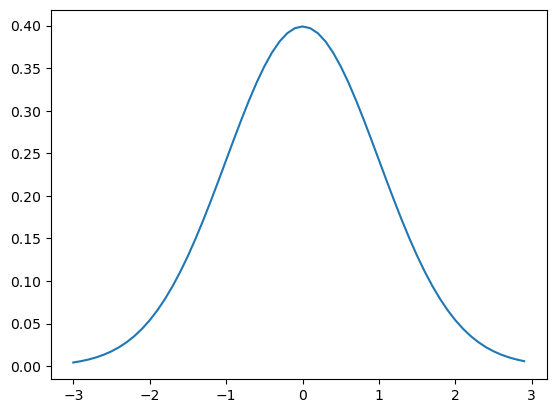

In [35]:
Z = (mean_v - mean_c)/np.sqrt(std_v**2/N_v + std_c**2/N_c)
pvalue = norm.sf(Z)

print("Z-score: {0}\np-value: {1}".format(Z,pvalue))

z = np.arange(-3, 3, 0.1)
plt.plot(z, norm.pdf(z))
plt.fill_between(z[z>Z], norm.pdf(z[z>Z]))
plt.show()

 the z test might lead to slightly different results in that case and the Xi test should be preferred.
 
 This difference may be explained by a slight weakness of the Z-test, which does not acknowledge here the binary nature of the rv: μ(B)-μ(A) is actually bounded in [-1,1] and the observation is therefore attributed a lower p-value.

## Online tools:
- https://cxl.com/ab-test-calculator/ (one sided sample size calculator) 
- https://www.evanmiller.org/ab-testing/sample-size.html#
- https://www.stat.ubc.ca/~rollin/stats/ssize/n2.html

## Sources

- Ztest, hypothesis and directionnality https://towardsdatascience.com/hypothesis-testing-z-scores-337fb06e26ab 
- statistical significance https://towardsdatascience.com/statistical-significance-hypothesis-testing-the-normal-curve-and-p-values-93274fa32687 
- non-inferiority testing https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2701110/pdf/nihms112245.pdf